# This Notebook generates plots from Fig2 and 3 from the paper.

In [94]:
#@title : Import useful packages

import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pandas as pd

from tools import kaczmarz_method, soft_skrinkage, Bregman_distance_dual, objective, dual_objective
from google.colab import files
from os.path import exists
import matplotlib

In [93]:
#@title : Latex installation

path_to_file = 'type1cm.zip'
file_exists = exists(path_to_file)

if file_exists == False:
  ! sudo apt-get install texlive-latex-recommended
  ! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
  ! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
  ! unzip type1cm.zip -d /tmp/type1cm
  ! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
  ! sudo mkdir /usr/share/texmf/tex/latex/type1cm
  ! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
  ! sudo texhash
  !apt install cm-super

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35
  libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libptexenc1 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern poppler-data t1utils tex-common texlive-base
  texlive-binaries texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  poppler-utils ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum debhelper gv | postscript-viewer perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc texlive-latex-recommended-doc
  texlive-luatex texlive-pstricks
The following NEW packages will be installed:
  dvisvgm fonts-droid-fa

In [95]:
#@title : Matplotlib configuration

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

SMALL_SIZE = 10 #8
MEDIUM_SIZE = 12 #10
BIGGER_SIZE = 14 #12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['text.usetex'] = True

  # activate latex text rendering
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')

# plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

In [2]:
#@title : Useful function

# Fixing random state for reproducibility
seed = 1234
np.random.seed(seed)

# making a vector x sparse with s non zero entries
def sparse(x, s):
    shape = x.shape

    arr = np.zeros(shape)
    arr[:s]  = 1
    np.random.shuffle(arr)
    return x * arr

### Setting


*   Given $\mathbf{A} \in \mathbb{R}^{m \times n}$ and a strongly function $f:\mathbb{R}^{n}\to\mathbb{R}$.
*    The matrix is partitioned into $M$ blocks of rows, i.e.
  \begin{align*}
    \mathbf{A} =
    \begin{pmatrix}
      \mathbf{A}_{(1)}\\\vdots\\\mathbf{A}_{(M)}
    \end{pmatrix}
  \end{align*}
  with $\mathbf{A}_{(i)}\in\mathbb{R}^{m_{i}\times n}$.
*   Assume that there exists ``true data $b\in\mathbb{R}^{m}$'' such that the system $\mathbf{A}x = b$ is consistent, we aim to compute the minimum-$f$-solution of $\mathbf{A}x = b$, i.e. the unique solution $\hat{x}$ of
\begin{align*}
\hat x :=\operatorname*{arg min}_{x\in\mathbb{R}^n} f(x) \quad \text{subject to}\quad \mathbf{A}x = b.
\end{align*}
*   We are not given $b$, but each time we query a the $i$-th block of $b$, i.e. $b_{(i)}\in\mathbb{R}^{m_{i}}$ we get a perturbation $\tilde{b}_{(i)}\in\mathbb{R}^{m_{(i)}}$ which is $\tilde{b}_{(i)} = b_{(i)} + \varepsilon_{(i)}$ where $\varepsilon_{(i)}$ is a random vector with zero mean and variance $\sigma_{i}^{2}$, i.e.
  \begin{align*}
    \mathbb{E}[\varepsilon_{(i)}] = 0,\quad  \text{and}\quad \mathbb{E}[\|\varepsilon_{(i)}\|^{2}] = \sigma_{i}^{2}.
  \end{align*}


In [3]:
#@title : Create the toy example

m = 2000 # number of equation
n = 100 # number of unknown

s = 10 # number of nonzeros in solution

A = np.random.randn(m,n)

# create a sparse solution with s non zero entries
x_true = sparse(np.random.randn(n,1),s)

b = A @ x_true

print(A.shape, x_true.shape, b.shape, s)

(2000, 100) (100, 1) (2000, 1) 10


In [90]:
#@title : Code for plotting

def plotData(data, labels, linestyles, colors, s=40, YLabel='', name= '', epoch=False, M=m):

    data_mean = []
    data_std = []
    Data_mean = []
    Data_std = []

    X = [k for k in range(len(data[0][0])) if k%s==0]

    for i in range(len(data)):
        data_mean.append(np.mean(data[i], axis=0, dtype=np.float64))
        data_std.append(np.std(data[i], axis=0, dtype=np.float64))

    for i in range(len(data)):
        Data_mean.append([data_mean[i][l] for l in X])
        Data_std.append([data_std[i][l] for l in X])

    plt.figure(figsize=(5,5))
    if epoch == True:
        X = [k/M for k in X]
    for i in range(len(data)):
        plt.plot(X, Data_mean[i],  linestyle=linestyles[i], label=labels[i], color=colors[i])
        plt.fill_between(X, np.subtract(Data_mean[i], Data_std[i]), np.add(Data_mean[i], Data_std[i]), color=colors[i], alpha=0.2)

    if epoch == True:
        plt.xlabel(r'epoch', fontsize=10)
    else:
        plt.xlabel(r'$\mathbf{k}$', fontsize=10)
    plt.yscale('log')
    plt.ylabel(YLabel, fontsize=10)
    plt.legend()
    plt.grid(True)
    if len(name) >1 :
        plt.savefig(name, format='pdf')
        files.download(name)
    plt.show()

In [5]:
#@title : Hyperparameters Tuning

gamma_list = [0.005, 0.01, 0.05, 0.1, 1, 2]
lambda_list = [0, 0.005, 0.05, 0.1, 0.5, 1, 3]
learning_rates = ['css', 'oss']

x_0 = np.zeros((n, 1))

max_iter = 10*m
number_block = [int(m/10)]
Data = []

# Fix the block partition
index_list = list([i for i in range(m)])
copy_index_list = index_list.copy()
# np.random.shuffle(copy_index_list)
P_lists = [np.array_split(copy_index_list, nb_block) for nb_block in number_block]

for nb_block in number_block:

    sigma_list = [0.05/(np.sqrt(nb_block)) for _ in range(nb_block)]
    # Fix the block partition of the matrix
    P_list = P_lists[0]

    for l_rate in learning_rates:
        for gma in gamma_list:
            for Lda in lambda_list:

                Result = kaczmarz_method(A, x_0, b, x_true, max_iter, sigma_list, gma, lbda=Lda, nber_block=nb_block, p_list=P_list, save_freq=1, lr = l_rate)

                data_results = dict()
                data_results['step_size'] = l_rate
                data_results['gamma'] = gma
                data_results['lambda'] = Lda
                data_results['number_block'] = nb_block
                data_results['error'] = Result[2][-1]
                data_results['residual'] = Result[1][-1]

                Data.append(data_results)

Computing beta_0 for lambda=0, beta_0=75344070.052593
Algorithm 1 : stepsize css = Constant stepsize, M = 200, shuffle = False, gamma = 0.005, lambda = 0 for 20000 iterations
Computing beta_0 for lambda=0.005, beta_0=38067149.36593563
Algorithm 1 : stepsize css = Constant stepsize, M = 200, shuffle = False, gamma = 0.005, lambda = 0.005 for 20000 iterations
Computing beta_0 for lambda=0.05, beta_0=41623178.42268791
Algorithm 1 : stepsize css = Constant stepsize, M = 200, shuffle = False, gamma = 0.005, lambda = 0.05 for 20000 iterations
Computing beta_0 for lambda=0.1, beta_0=45574321.81907932
Algorithm 1 : stepsize css = Constant stepsize, M = 200, shuffle = False, gamma = 0.005, lambda = 0.1 for 20000 iterations
Computing beta_0 for lambda=0.5, beta_0=77183468.99021056
Algorithm 1 : stepsize css = Constant stepsize, M = 200, shuffle = False, gamma = 0.005, lambda = 0.5 for 20000 iterations
Computing beta_0 for lambda=1, beta_0=116694902.95412467
Algorithm 1 : stepsize css = Constant 

In [6]:
df = pd.DataFrame.from_dict(Data)
df

,step_size,gamma,lambda,number_block,error,residual
0,css,0.005,0.000,200,0.000322,0.000317
1,css,0.005,0.005,200,0.000076,0.000075
2,css,0.005,0.050,200,0.000097,0.000096
3,css,0.005,0.100,200,0.000073,0.000071
4,css,0.005,0.500,200,0.000065,0.000064
...,...,...,...,...,...,...
79,oss,2.000,0.050,200,0.516298,0.510745
80,oss,2.000,0.100,200,0.569084,0.566168
81,oss,2.000,0.500,200,0.844723,0.844218
82,oss,2.000,1.000,200,0.974972,0.975030


In [7]:
df[df['error'] == min(df['error'])]

,step_size,gamma,lambda,number_block,error,residual
66,oss,0.1,0.1,200,0.000002,0.000002


In [8]:
Lambda_rsk = df[df['error'] == min(df['error'])]['lambda']
df1 = df[df['lambda'] == Lambda_rsk.iloc[0]]

Gamma_rsk = df1[df1['error'] == min(df1['error'])]['gamma']

Lambda_rsk = df1[df1['error'] == min(df1['error'])]['lambda']

nber_block = df1[df1['error'] == min(df1['error'])]['number_block']
print(Lambda_rsk.iloc[0], Gamma_rsk.iloc[0], nber_block.iloc[0])

0.1 0.1 200


In [9]:
df2 = df[df['lambda'] == 0.0]

Gamma_rk = df2[df2['error'] == min(df2['error'])]['gamma']

Lambda_rk = df2[df2['error'] == min(df2['error'])]['lambda']

print(Lambda_rk.iloc[0], Gamma_rk.iloc[0])
print(df2[df2['error'] == min(df2['error'])])

0.0 0.05
   step_size  gamma  lambda  number_block     error  residual
56       oss   0.05     0.0           200  0.000011   0.00001


In [66]:
lambda_rsk = Lambda_rsk.iloc[0]
lambda_rk = 0.0
gamma_rk = Gamma_rk.iloc[0]
gamma_rsk =  Gamma_rsk.iloc[0]
number_block_abk = int(m/10)
Repeats = 1  # The number of time we want to repeat the experiment
print(lambda_rsk, gamma_rsk, lambda_rk, gamma_rk, number_block_abk)

0.05 0.1 0.0 0.05 200


In [67]:
P_list = P_lists[0]

sigma = 0.05
sigma_list = [sigma/(np.sqrt(number_block_abk)) for _ in range(number_block_abk)]

In [68]:
#@title : randomized Kaczmarz

x_0 = np.zeros((n, 1))

x_rk, residuals_rk, errors_rk = np.zeros((Repeats, n, 1)), np.zeros((Repeats, max_iter+1)), np.zeros((Repeats, max_iter+1))
lr_values_rk =  np.zeros((Repeats, max_iter))

for r in range(Repeats):
    x, residuals, errors, lr_values, _ = kaczmarz_method(A, x_0, b, x_true, max_iter, sigma_list, gamma_rk,
                                                         lbda=lambda_rk, nber_block=number_block_abk, p_list=P_list)
    x_rk[r] = x
    residuals_rk[r] = residuals
    errors_rk[r] = errors
    lr_values_rk[r] = lr_values

Computing beta_0 for lambda=0.0, beta_0=75344070.052593
Algorithm 1 : stepsize css = Constant stepsize, M = 200, shuffle = False, gamma = 0.05, lambda = 0.0 for 20000 iterations


In [69]:
#@title : randomized Kaczmarz with adaptive step size

x_0 = np.zeros((n, 1))

x_ark, residuals_ark, errors_ark = np.zeros((Repeats, n, 1)), np.zeros((Repeats, max_iter+1)), np.zeros((Repeats, max_iter+1))
lr_values_ark, beta_values_ark =  np.zeros((Repeats, max_iter)), np.zeros((Repeats, max_iter))

for r in range(Repeats):
    x, residuals, errors, lr_values, beta_values = kaczmarz_method(A, x_0, b, x_true, max_iter, sigma_list, gamma_rk,
                                                                   lbda=lambda_rk, nber_block=number_block_abk, p_list=P_list, lr = 'oss')
    x_ark[r] = x
    residuals_ark[r] = residuals
    errors_ark[r] = errors
    lr_values_ark[r] = lr_values
    beta_values_ark[r] = beta_values

Computing beta_0 for lambda=0.0, beta_0=75344070.052593
Algorithm 1 : stepsize oss = Optimal stepsize, M = 200, shuffle = False, gamma = 0.05, lambda = 0.0 for 20000 iterations


In [70]:
#@title : randomized sparse Kaczmarz

x_0 = np.zeros((n, 1))

x_rsk, residuals_rsk, errors_rsk = np.zeros((Repeats, n, 1)), np.zeros((Repeats, max_iter+1)), np.zeros((Repeats, max_iter+1))
lr_values_rsk =  np.zeros((Repeats, max_iter))
dual_iterates_rsk = []

for r in range(Repeats):
    x, residuals, errors, lr_values, _, dual_iterates= kaczmarz_method(A, x_0, b, x_true, max_iter, sigma_list, gamma_rsk,
                                                                       lbda=lambda_rsk, nber_block=number_block_abk, p_list=P_list, keep=True)
    x_rsk[r] = x
    residuals_rsk[r] = residuals
    errors_rsk[r] = errors
    lr_values_rsk[r] = lr_values
    dual_iterates_rsk.append(dual_iterates)

Computing beta_0 for lambda=0.05, beta_0=41623178.42268791
Algorithm 1 : stepsize css = Constant stepsize, M = 200, shuffle = False, gamma = 0.1, lambda = 0.05 for 20000 iterations


In [71]:
#@title : randomized sparse Kaczmarz with adaptive step size

x_0 = np.zeros((n, 1))

x_arsk, residuals_arsk, errors_arsk = np.zeros((Repeats, n, 1)), np.zeros((Repeats, max_iter+1)), np.zeros((Repeats, max_iter+1))
lr_values_arsk, beta_values_arsk =  np.zeros((Repeats, max_iter)), np.zeros((Repeats, max_iter))

for r in range(Repeats):
    x, residuals, errors, lr_values, beta_values = kaczmarz_method(A, x_0, b, x_true, max_iter, sigma_list, gamma_rsk,
                                                                   lbda=lambda_rsk, nber_block=number_block_abk, p_list=P_list, lr = 'oss')
    x_arsk[r] = x
    residuals_arsk[r] = residuals
    errors_arsk[r] = errors
    lr_values_arsk[r] = lr_values
    beta_values_arsk[r] = beta_values

Computing beta_0 for lambda=0.05, beta_0=41623178.42268791
Algorithm 1 : stepsize oss = Optimal stepsize, M = 200, shuffle = False, gamma = 0.1, lambda = 0.05 for 20000 iterations


# Heuristic estimation of the parameters $\gamma$  and $\beta_0$.

Given $N_0$, $$\frac{\tilde{\gamma}}{2} = 1 - \mathbb{E}[\frac{D_f^{x_{j}^*}(x_{j},x_N)}{D_f^{x_{j-1}^*}(x_{j-1},x_N)}] = 1 - \frac{1}{N_0} \sum_{j=1}^{N_0} \frac{D_f^{x_{j}^*}(x_{j},x_N)}{D_f^{x_{j-1}^*}(x_{j-1},x_N)}$$

In [76]:
N0 = 400
dual_iterates = dual_iterates_rsk[0]
x_rsk1 = x_rsk[0]
NumIter = len(dual_iterates)
result = 0
for i in range(N0):
    c1 = Bregman_distance_dual(dual_iterates[i+1], x_rsk1, lambda_rsk)
    c2 = Bregman_distance_dual(dual_iterates[i], x_rsk1, lambda_rsk)

    result += c1/c2
result /= N0
gamma_est = 2*(1 - result)
print(f'estimation of gamma : {gamma_est}')

estimation of gamma : 0.07775365947049928


Given $N$ and $N_1$, $$\tilde{\beta}_0^{-1} =  \frac{\tilde{\gamma}}{N_1} \sum_{j=N-N_1}^{N-1} \frac{D_f^{x_{j}^*}(x_{j},x_N)}{D(x_0, x_N)}$$

In [84]:
N1 =  100

Result1 = 0
x_0 = np.zeros((n, 1))
b2 = Bregman_distance_dual(x_0, x_rsk1, lambda_rsk)
for j in range(NumIter-N1, NumIter):
    b1 = Bregman_distance_dual(dual_iterates[j], x_rsk1, lambda_rsk)
    Result1 += b1

Result = (gamma_est * Result1) / (N1 * b2)
beta_est = 1/Result
print(f'estimation of beta zero : {beta_est}')

estimation of beta zero : 1022604301.8737379


In [85]:
#@title : Sparse Kaczmarz with adaptive step size

x_0 = np.zeros((n, 1))
beta_start_harsk = beta_est
gamma_harsk = gamma_est

x_harsk, residuals_harsk, errors_harsk = np.zeros((Repeats, n, 1)), np.zeros((Repeats, max_iter+1)), np.zeros((Repeats, max_iter+1))
lr_values_harsk, beta_values_harsk =  np.zeros((Repeats, max_iter)), np.zeros((Repeats, max_iter))

for r in range(Repeats):
    x, residuals, errors, lr_values, beta_values = kaczmarz_method(A, x_0, b, x_true, max_iter, sigma_list, gamma_harsk,
                                                                   lbda=lambda_rsk, nber_block=number_block_abk, p_list=P_list, beta=beta_start_harsk, lr = 'oss')
    x_harsk[r] = x
    residuals_harsk[r] = residuals
    errors_harsk[r] = errors
    lr_values_harsk[r] = lr_values
    beta_values_harsk[r] = beta_values

Algorithm 1 : stepsize oss = Optimal stepsize, M = 200, shuffle = False, gamma = 0.07775365947049928, lambda = 0.05 for 20000 iterations


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

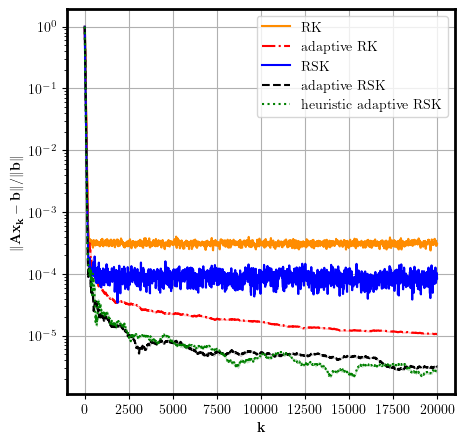

In [96]:
labels = ['RK', 'adaptive RK', 'RSK', 'adaptive RSK', 'heuristic adaptive RSK']
linestyles = ['solid','-.', 'solid', 'dashed', 'dotted']
colors = ['darkorange', 'red', 'blue', 'black', 'green', 'darkorange', 'forestgreen']

y_label = '$\mathbf{\|Ax_k - b\|/\|b\|}$'

plotname = 'residuals_{}_{}.pdf'.format(m,n)
plotData([residuals_rk, residuals_ark, residuals_rsk, residuals_arsk, residuals_harsk], labels, linestyles, colors, s=10, YLabel=y_label, name=plotname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

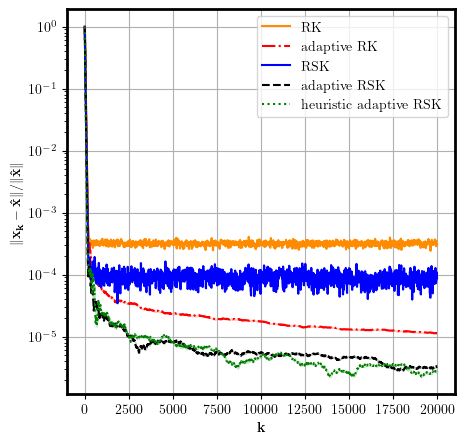

In [97]:
labels = ['RK', 'adaptive RK', 'RSK', 'adaptive RSK', 'heuristic adaptive RSK']
linestyles = ['solid','-.', 'solid', 'dashed', 'dotted']

colors = ['darkorange', 'red', 'blue', 'black', 'green', 'darkorange', 'forestgreen']
y_label = '$\mathbf{\|x_k - \hat x\|/\|\hat x\|}$'
plotname = 'errors_{}_{}.pdf'.format(m,n)
plotData([errors_rk, errors_ark, errors_rsk, errors_arsk, errors_harsk], labels, linestyles, colors, s=10, YLabel=y_label, name=plotname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

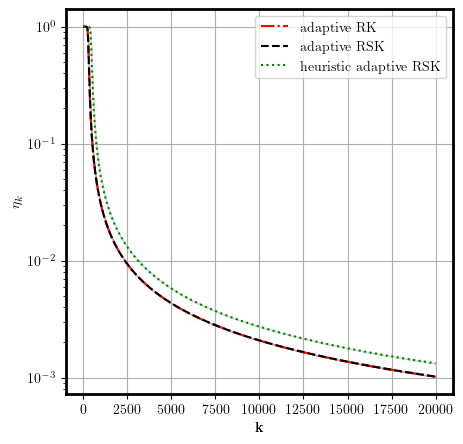

In [98]:
labels = ['adaptive RK', 'adaptive RSK', 'heuristic adaptive RSK']
linestyles = ['-.', 'dashed', 'dotted']
colors = ['red', 'black', 'green']
y_label = '$\eta_k$'
plotname = 'eta_{}_{}.pdf'.format(m,n)
plotData([lr_values_ark, lr_values_arsk, lr_values_harsk], labels, linestyles, colors, s=10, YLabel=y_label, name=plotname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

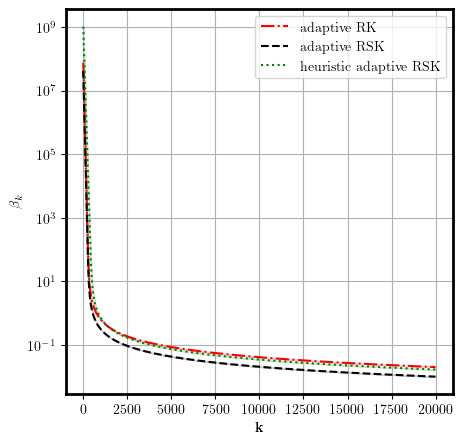

In [99]:
labels = ['adaptive RK', 'adaptive RSK', 'heuristic adaptive RSK']
linestyles = ['-.', 'dashed', 'dotted']
colors = ['red', 'black', 'green']
y_label = '$\\beta_k$'
plotname = 'beta_{}_{}.pdf'.format(m,n)
plotData([beta_values_ark, beta_values_arsk, beta_values_harsk], labels, linestyles, colors, s=10, YLabel=y_label, name=plotname)